# Table of Contents

1. [Imports](#Imports)
2. [VADER Sentiment Analysis](#VADER-Sentiment-Analysis)
    1. [Modeling with CountVectorizer and LogisticRegression](#Modeling-with-CountVectorizer-and-LogisticRegression)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('./data/subreddits_EDA.csv')

In [3]:
print(df.shape)
df.head()

(16533, 9)


,subreddit,author,title,selftext,score,created_utc,eastern_time,post_word_count,title_word_count
0,Oxygennotincluded,TrumpByPublicOpinion,Mod Idea - In game Programmable Logic Controllers,"Hey everyone,\n\nBeen playing the game some ti...",1,1599762597,2020-09-10 14:29:57,108,8
1,Oxygennotincluded,DaHedgehog27,Mod Request - Removing Construction Supply fro...,I have zero clue when it comes to modding this...,1,1599752065,2020-09-10 11:34:25,104,8
2,Oxygennotincluded,KittehNevynette,Fertiliser flatulence power question. How much?,I saw a YT video where fertiliser synthesisers...,1,1599745896,2020-09-10 09:51:36,159,6
3,Oxygennotincluded,Turalyon135,Automation question,Is there a way using a gate or any kind to hav...,1,1599737435,2020-09-10 07:30:35,148,2
4,Oxygennotincluded,FoxRealistic3370,Perseverance or Experience,SOOOOO im on about cycle 1500 of my first base...,1,1599730988,2020-09-10 05:43:08,294,3


In [4]:
df['stripped_text'] = df['selftext'].replace('\nhttp\S+', '', regex=True).replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True).replace('\n\S+', '', regex=True)

In [5]:
df.head()

,subreddit,author,title,selftext,score,created_utc,eastern_time,post_word_count,title_word_count,stripped_text
0,Oxygennotincluded,TrumpByPublicOpinion,Mod Idea - In game Programmable Logic Controllers,"Hey everyone,\n\nBeen playing the game some ti...",1,1599762597,2020-09-10 14:29:57,108,8,"Hey everyone, playing the game some time now a..."
1,Oxygennotincluded,DaHedgehog27,Mod Request - Removing Construction Supply fro...,I have zero clue when it comes to modding this...,1,1599752065,2020-09-10 11:34:25,104,8,I have zero clue when it comes to modding this...
2,Oxygennotincluded,KittehNevynette,Fertiliser flatulence power question. How much?,I saw a YT video where fertiliser synthesisers...,1,1599745896,2020-09-10 09:51:36,159,6,I saw a YT video where fertiliser synthesisers...
3,Oxygennotincluded,Turalyon135,Automation question,Is there a way using a gate or any kind to hav...,1,1599737435,2020-09-10 07:30:35,148,2,Is there a way using a gate or any kind to hav...
4,Oxygennotincluded,FoxRealistic3370,Perseverance or Experience,SOOOOO im on about cycle 1500 of my first base...,1,1599730988,2020-09-10 05:43:08,294,3,SOOOOO im on about cycle 1500 of my first base...


# VADER Sentiment Analysis

In [6]:
sia = SentimentIntensityAnalyzer()

In [7]:
# Code adapted from local lect: Modeling with VADER

dicts = []    

for post in df['stripped_text']:   #loops through the individual post in the corpus
    scores = sia.polarity_scores(post)   #gets the sentiment scores for each post
    scores['text'] = post #puts post in a 'text' column
    dicts.append(scores)  #adds scores & text to empty dictionary

df_sia = pd.DataFrame(dicts)   #makes dataframe from empty dictionary
df_sia.head()

,neg,neu,pos,compound,text
0,0.047,0.781,0.173,0.9107,"Hey everyone, playing the game some time now a..."
1,0.031,0.936,0.033,0.0387,I have zero clue when it comes to modding this...
2,0.040,0.841,0.119,0.9226,I saw a YT video where fertiliser synthesisers...
3,0.083,0.830,0.087,-0.3400,Is there a way using a gate or any kind to hav...
4,0.049,0.764,0.187,0.9921,SOOOOO im on about cycle 1500 of my first base...


In [8]:
df_sia.shape

(16533, 5)

In [9]:
df_sia['subreddit'] = df['subreddit'].copy()

<Figure size 720x576 with 0 Axes>

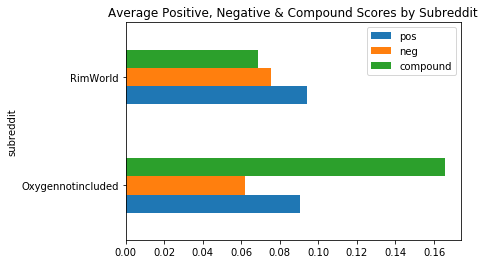

In [10]:
plt.figure(figsize = (10, 8));
df_sia.groupby('subreddit').mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Scores by Subreddit');

In [28]:
df_sia.groupby('subreddit')['compound'].mean()

subreddit
Oxygennotincluded    0.165461
RimWorld             0.068434
Name: compound, dtype: float64

## Modeling with CountVectorizer and LogisticRegression

In [11]:
X = df_sia[['text', 'compound', 'neg', 'neu', 'pos']]
y = df_sia['subreddit']

In [12]:
y.value_counts(normalize=True)

Oxygennotincluded    0.549205
RimWorld             0.450795
Name: subreddit, dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3000, stratify = y)

In [14]:
cvec = CountVectorizer(stop_words = 'english')
Z_train = cvec.fit_transform(X_train['text'])
Z_test = cvec.transform(X_test['text'])

In [15]:
df_Z_train = pd.DataFrame(Z_train.todense(), 
                          columns=cvec.get_feature_names())

In [16]:
df_Z_test = pd.DataFrame(Z_test.todense(), 
                         columns = cvec.get_feature_names())

In [17]:
df_Z_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)

df_Z_test.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

In [18]:
combined_Z_train = pd.concat([df_Z_train, X_train], axis =1)
combined_Z_train.head(1)

,00,000,0000,000000nothing,0000kcal,0001k,000g,000germs,000kcal,000kg,...,ᶠᵘᶜᵏ,ᶦˢ,ᶦᶠ,ㅠㅜ,刷新选人,text,compound,neg,neu,pos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,I know that you can't stack clothing/guns beca...,-0.395,0.108,0.892,0.0


In [19]:
combined_Z_test = pd.concat([df_Z_test, X_test], axis =1)
combined_Z_test.head(1)

,00,000,0000,000000nothing,0000kcal,0001k,000g,000germs,000kcal,000kg,...,ᶠᵘᶜᵏ,ᶦˢ,ᶦᶠ,ㅠㅜ,刷新选人,text,compound,neg,neu,pos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,I was watching some videos about base cooling ...,0.915,0.054,0.775,0.17


In [20]:
combined_Z_train.drop(columns = 'text', inplace=True)
combined_Z_test.drop(columns = 'text', inplace = True)

In [21]:
logreg = LogisticRegression(solver = 'liblinear')

In [22]:
cross_val_score(logreg, combined_Z_train, y_train).mean()

0.9168482348501608

In [23]:
logreg.fit(combined_Z_train, y_train)

LogisticRegression(solver='liblinear')

In [24]:
logreg.score(combined_Z_train, y_train), logreg.score(combined_Z_test, y_test)

(0.9765303653520445, 0.9165457184325109)

In [25]:
preds_sia = logreg.predict(combined_Z_test)

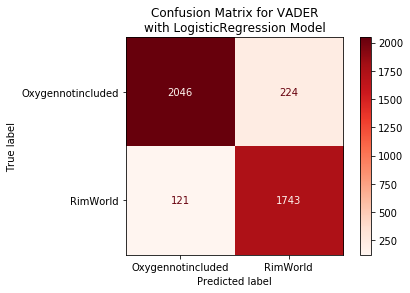

In [26]:
plot_confusion_matrix(logreg, combined_Z_test, y_test, cmap = 'Reds', values_format = 'd')
plt.title('Confusion Matrix for VADER\nwith LogisticRegression Model', fontsize = 12);